<a href="https://colab.research.google.com/github/johanhoffman/DD2363-VT20/blob/lindevanbeers/Lab-7/Linde-report-lab-7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Lab 7: Optimisation and learning**
**Linde van Beers**

#**About the code**

A short statement on who is the author of the file, and if the code is distributed under a certain license. 

In [5]:
"""This program is a template for lab reports in the course"""
"""DD2363 Methods in Scientific Computing, """
"""KTH Royal Institute of Technology, Stockholm, Sweden."""

# Linde van Beers 2020

# Template:
# Copyright (C) 2019 Johan Hoffman (jhoffman@kth.se)

# This file is part of the course DD2363 Methods in Scientific Computing
# KTH Royal Institute of Technology, Stockholm, Sweden
#
# This is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# This template is maintained by Johan Hoffman
# Please report problems to jhoffman@kth.se

'KTH Royal Institute of Technology, Stockholm, Sweden.'

# **Set up environment**

To have access to the neccessary modules you have to run this cell. If you need additional modules, this is where you add them. 

In [0]:
# Load neccessary modules.
from google.colab import files

import time
import numpy as np

from matplotlib import pyplot as plt
from matplotlib import tri
from matplotlib import axes
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D

# **Introduction**

This week the lab focused on optimisation and learning methods. I implemented gradient descent and backpropagation, both of which are important in training neural networks. I tested both functions. 


# **Methods**

###Function: Gradient descent method in Rn 


Input: objective function f(x) 

Output: stationary point x* such that || grad(f)(x*) || < TOL

In [0]:
def compute_gradient(f,x):
  Df = x.copy()
  eps = 1e-10
  for i in range(x.shape[0]):
    x1 = x.copy()
    x2 = x.copy()
    x1[i] = x1[i]-eps
    x2[i] = x2[i]+eps
    Df[i] = (f(x2)-f(x1))/(2*eps)
  return Df

def get_step_length(f,x,Df):
  beta = 0.2
  t = beta
  a = f(x)
  while a-abs(a*(t**4)) < f(x-t*Df): # beta*f(x) would not work with negative values, but I still wanted something that goes to f(x) as Df goes to 0
    t = t*beta
  return t

def gradient_descent(f, x0, tol = 0.001):
  x = x0
  xs = np.matrix(x0)
  Df = compute_gradient(f,x)
  while np.linalg.norm(Df) > tol:
    Df = compute_gradient(f,x)
    alpha = get_step_length(f,x,Df)
    x = x - alpha*Df
    xs = np.concatenate((xs,np.matrix(x)), axis = 0)
  return x, xs

### Function: Backpropagation algorithm for neural network 

Input: neural network , training data 

Output: trained network


In [0]:
def sigmoid(x):
  return (2/(1 + np.exp(-x))) - 1

def predict(model, X):
  output = X
  for i in range(0, len(model)):
    inputs = np.append(output,[np.ones(output.shape[1])], axis = 0)
    output = sigmoid(np.matmul(model[i], inputs))
  return output

def backprop(model, X, T, eta = 0.01):

  # forward pass
  inputs = [np.append(X,[np.ones(X.shape[1])], axis = 0)]
  outputs =  [sigmoid(np.matmul(model[0], inputs[0]))]
  for i in range(1, len(model)):
    inputs.append(np.append(outputs[i-1],[np.ones(outputs[i-1].shape[1])], axis = 0))
    outputs.append(sigmoid(np.matmul(model[i] , inputs[i])))

  error = outputs[-1]-T

  #  backward pass
  for i in range(len(model)-1, -1, -1):
    delta = np.multiply(error,np.multiply(1 + outputs[i], 1 - outputs[i])/2.)
    error = np.matmul(model[i].T, delta)[:-1, :]
    dw = np.matmul(delta,inputs[i].T)
    model[i] = model[i] - eta*dw
  
  return model

# **Results**

I tested my algorith for gradient descent on the function 

$f(x,y) = x^2 + \frac{1}{2}y^2$

because it has the easy to calculate minimum at $(0,0)$.

I initialised gradient descent with an x0 somewhat away from the minimum, and checked if the output had converged sufficiently such that $||\nabla f(x^*)||< tol$. I also plotted the intermediate steps of gradient descent on a contour map. 

output: [6.56230795e-25 6.83515716e-11]
target: [0, 0]
||gradient||: 6.835157159226097e-11


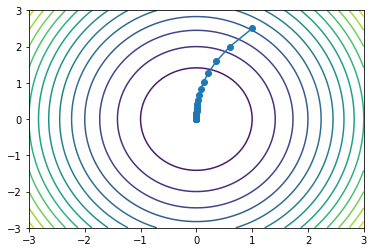

In [228]:
f = lambda x: (x[0]**2 + x[1]**2/2)

n = 100
X = np.array(np.linspace(-3,3,n))
Y = np.array(np.linspace(-3,3,n))
Z = np.zeros([n,n])

x, xs = gradient_descent(f, np.array([1,2.5]), 1e-10)

for i in range(n):
  for j in range(n):
    Z[i,j] = f([X[j],Y[i]])

fig = plt.figure()
sub = fig.add_subplot(111)
sub.set_xlim(-3,3)
sub.set_ylim(-3,3)
CS = sub.contour(X,Y,Z, 15)
sub.plot(xs[:,0],xs[:,1], 'o-')
print('output:',x)
print('target:', [0, 0])
print('||gradient||:',np.linalg.norm(compute_gradient(f,x)))

I made a model with randomly initialised weigh from a normal distribution $N\sim [0,1]$

I made a training set and validation set with slightly shifted data points, both from the distribution: 

$e^{-x^{2}/10}*e^{-y^{2}/10}-\frac{1}{2}$

I chose this because the results are between 1 and -1.

I then trained my model using backpropagation using the training set, and predicted the outputs of the validation set after training the model. I plotted the prediction against the target and calculated the mean absolute error as an indicator of the performance of the algorithm. 

mean error: 0.0028878396499889963


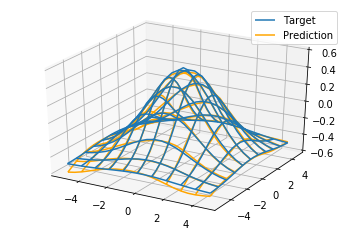

In [231]:
# model (= weight matrices)
in_size = 2
h_size = 5 #size of the hidden layer
out_size = 1
in_to_h = np.random.normal(0,1,[h_size,in_size+1])
h_to_out = np.random.normal(0,1,[out_size, h_size+1])
model = [in_to_h,h_to_out]

# training set
x = np.matrix(np.array(np.linspace(-5,5,21))).T
y = np.matrix(np.array(np.linspace(-5,5,21))).T
z = np.exp(np.multiply(-x,x)*0.1) * np.exp(np.multiply(-y,y)*0.1).T - 0.5 
outs = np.reshape(z,21*21)
xx,yy = np.meshgrid(x,y)
xx = np.reshape(xx,21*21)
yy = np.reshape(yy,21*21)
ins = np.append(xx,yy, axis = 0)

# validation set 
x = np.matrix(np.array(np.linspace(-5.25,4.75,21))).T
y = np.matrix(np.array(np.linspace(-5.25,4.75,21))).T
z = np.exp(np.multiply(-x,x)*0.1) * np.exp(np.multiply(-y,y)*0.1).T - 0.5 
outs_v = np.reshape(z,21*21)
xx,yy = np.meshgrid(x,y)
xc = np.reshape(xx,21*21)
yc = np.reshape(yy,21*21)
ins_v = np.append(xc,yc, axis = 0)

# ins = np.ones([2,10])
# outs = np.ones([1,10])
epochs = 1000

# train on training data
for i in range(epochs):
  model = backprop(model, ins, outs)

prediction = predict(model,ins_v)

# plot result on validation data
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_zlim3d( -0.6,0.6 )
target = ax.plot_wireframe(xx, yy, np.reshape(outs_v,[21,21]) , rcount = 15, ccount = 15, label = "Target")
pred = ax.plot_wireframe(xx, yy, np.reshape(prediction,[21,21]) , rcount = 15, ccount = 15, label = "Prediction", colors = 'orange')
plt.legend()

# print accuracy measured by mean error on validation data
print('mean error:',np.linalg.norm(prediction-outs_v)/144)

# **Discussion**

The tests for both functions were successful. 

In gradient descent I found the most important feature to play with was the step size, for which I tried multiple different approaches. Some of the approaches mentioned in the lecture notes did not work for me as I was testing at first with functions that had minima below or above zero. With some experimentation I came up with my own. It is probably not the most efficient one, but it does work. 

For backpropagation I felt the most influential elements were the learning rate and the number of epochs. A high learning rate results in unstable training, while a low one causes very slow training. As for epochs more is generally better.